In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from lib.constants import DATA_FOLDER, TMP_FOLDER, SUBMISSION_FOLDER
from lib.dataload import load_data
import numpy as np
from lib.utils import make_submission_from_hdf
df_train, df_target, df_test = load_data(read=True, reduce_mem=False)
df_train['is_train'] = 1
df_test['is_train'] = 0
train_test = pd.concat([df_train, df_test], sort=False)

... Reading ...
-- Done


In [2]:
nmods_data = []
for param in train_test.columns:
    nmods = train_test[param].nunique()
    nmods_data.append(nmods)

df_nmods = pd.DataFrame(list(train_test.columns), columns=['param'])
df_nmods['nmods'] = nmods_data

sel_cols = list(set(df_nmods.columns) - set(['is_train', 'target']))

look_cols = list(df_nmods[sel_cols].sort_values('nmods').head(20)['param'].values[2:])

In [3]:
count_cols = []
for col in look_cols:
    colname = 'count_' + col
    count_cols.append(colname)
    tmp = (
        pd.DataFrame(train_test.groupby([col])['ID_code']
                     .count().reset_index()
                     .rename(columns={'ID_code': colname}))
    )
    train_test = train_test.merge(tmp, on=[col])

In [4]:
for col in count_cols:
    df_a = pd.cut(train_test[col], train_test[col].nunique()).value_counts().sort_index()
    df_a = df_a.reset_index().rename(columns={'index': 'bin'}).reset_index()
    df_a['diff'] = df_a[col].diff().fillna(0)
    df_a['delta_0'] = np.around((df_a[col] - 0 )/ (df_a['index'] + 1), decimals=0)
    
    step = (train_test[col].max()-train_test[col].min())/train_test[col].nunique()
    tmp2 = pd.DataFrame(train_test[col].drop_duplicates()).sort_values(by=col)
    group_col = 'group_' + col
    tmp2[group_col] = tmp2[col].apply(lambda x: int(df_a.iloc[np.minimum(int(x/step),
                                                  train_test[col].nunique()-1), 4]))
    train_test = train_test.merge(tmp2, on=col)

In [5]:
print("- Resplit train/test")
train = train_test[train_test['is_train'] == 1]
test = train_test[train_test['is_train'] == 0]

- Resplit train/test


# Model

In [24]:
%load_ext autoreload
%autoreload 2
from lib.model import train_lgbm_fold_classif, plot_importances

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
train.to_hdf('./data_tmp/new_train.hdf', 'df')
test.to_hdf('./data_tmp/new_test.hdf', 'df')

In [25]:
# Code
remove_cols = ['target', 'ID_code']
features = list(set(train.columns) - set(remove_cols))

importances, df_oof_preds, df_preds = train_lgbm_fold_classif(train, test, features, train['target'],
                              repeat_cv=1, n_splits=4,
                              n_max_estimators=10000
                              )

== INIT ==
== START MODEL TRAIN
== REPEAT CV 0
==== CV 0
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.761376	valid_1's auc: 0.753985
[200]	training's auc: 0.795523	valid_1's auc: 0.789581
[300]	training's auc: 0.818739	valid_1's auc: 0.810904
[400]	training's auc: 0.830849	valid_1's auc: 0.822611
[500]	training's auc: 0.841562	valid_1's auc: 0.833022
[600]	training's auc: 0.849625	valid_1's auc: 0.839783
[700]	training's auc: 0.855819	valid_1's auc: 0.846437
[800]	training's auc: 0.862066	valid_1's auc: 0.852248
[900]	training's auc: 0.867343	valid_1's auc: 0.857265
[1000]	training's auc: 0.870665	valid_1's auc: 0.860257
[1100]	training's auc: 0.87414	valid_1's auc: 0.863112
[1200]	training's auc: 0.876702	valid_1's auc: 0.865296
[1300]	training's auc: 0.879101	valid_1's auc: 0.867999
[1400]	training's auc: 0.881301	valid_1's auc: 0.870324
[1500]	training's auc: 0.883767	valid_1's auc: 0.872588
[1600]	training's auc: 0.885638	valid_1's auc: 0.8

[3000]	training's auc: 0.900335	valid_1's auc: 0.891962
[3100]	training's auc: 0.90098	valid_1's auc: 0.892396
[3200]	training's auc: 0.901466	valid_1's auc: 0.89282
[3300]	training's auc: 0.902039	valid_1's auc: 0.893287
[3400]	training's auc: 0.902485	valid_1's auc: 0.893656
[3500]	training's auc: 0.902991	valid_1's auc: 0.894254
[3600]	training's auc: 0.903461	valid_1's auc: 0.894547
[3700]	training's auc: 0.903691	valid_1's auc: 0.894605
[3800]	training's auc: 0.904128	valid_1's auc: 0.894635
[3900]	training's auc: 0.904561	valid_1's auc: 0.895031
[4000]	training's auc: 0.904925	valid_1's auc: 0.895324
[4100]	training's auc: 0.905318	valid_1's auc: 0.895748
[4200]	training's auc: 0.905766	valid_1's auc: 0.896177
[4300]	training's auc: 0.906115	valid_1's auc: 0.89655
[4400]	training's auc: 0.906411	valid_1's auc: 0.896904
[4500]	training's auc: 0.906715	valid_1's auc: 0.897194
[4600]	training's auc: 0.907015	valid_1's auc: 0.897319
[4700]	training's auc: 0.907187	valid_1's auc: 0.89

4


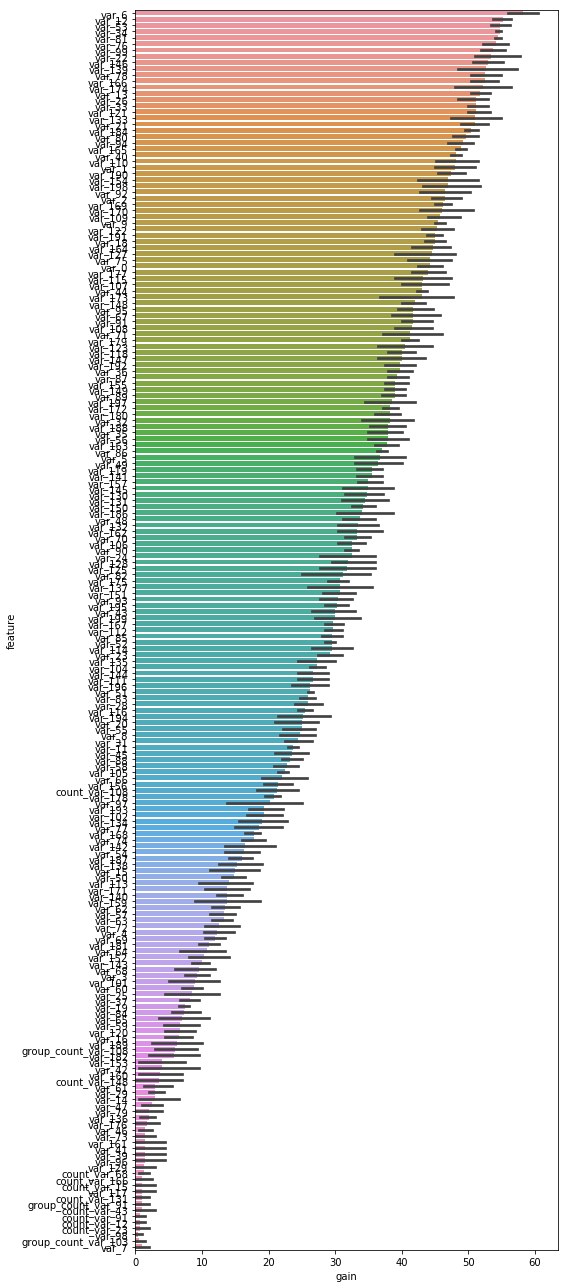

,feature,gain,model,fold,mean_gain
142,var_6,57,0,0,58.25
142,var_6,55,0,1,58.25
142,var_6,61,0,3,58.25
142,var_6,60,0,2,58.25
78,var_12,56,0,0,55.25
78,var_12,57,0,3,55.25
78,var_12,55,0,1,55.25
78,var_12,53,0,2,55.25
183,var_53,53,0,1,54.75
206,var_34,54,0,2,54.75


In [26]:
plot_importances(importances, num_features=200)

# Submissions

In [14]:
test['ID_code'].reset_index().head()

,index,ID_code
0,3,test_21033
1,5,test_145813
2,7,test_195689
3,9,test_149467
4,10,test_132053


In [21]:
df_pred_file = df_preds.merge(test['ID_code'].reset_index(), on=df_preds.index)[['ID_code', 0]].rename(columns={0:'target'})
df_pred_file.to_csv('./data_tmp/test_pred.csv', index=False)

In [9]:
filename = 'preds_lgbm_classif_CV_0.88763_TR_0.98783'
filename = 'preds_lgbm_classif_CV_0.89800_TR_0.91159'
make_submission_from_hdf(filename, test['ID_code'])

,ID_code,target
0,test_0,0.382775
1,test_1,0.726445
2,test_2,0.035494
3,test_3,0.017182
4,test_4,0.041979
5,test_5,0.050485
6,test_6,0.038306
7,test_7,0.053359
8,test_8,0.586925
9,test_9,0.052770


In [ ]:
filename